# Multilayer Perceptron (MLP) Model

This project aims to detect whether a bidder in an online auction is a human or a robot using a Multilayer Perceptron (MLP) model. The dataset is based on bidding behavior, including features such as bid timing, device, country, and auction patterns.

The prediction target is the outcome column, where:

0 = Human bidder

1 = Robot bidder (bot)


## Import and Explore the Data

In [1]:
import pandas as pd
import numpy as np

Load the Data

In [2]:
# Load the cleaned merged train data
merged_train_df = pd.read_csv('/kaggle/input/cleaned-trained-data/cleaned_train (1).txt')
merged_test_df = pd.read_csv('/kaggle/input/cleaned-test-dataset/cleaned_test.txt')

# Load the raw data for extra feature engineering
train_df = pd.read_csv('/kaggle/input/facebook-recruiting-iv-human-or-bot/train.csv.zip')
test_df = pd.read_csv('/kaggle/input/facebook-recruiting-iv-human-or-bot/test.csv.zip')
bids_df = pd.read_csv('/kaggle/input/facebook-recruiting-iv-human-or-bot/bids.csv.zip')

Preview the Data

In [3]:
print("Cleaned merged_train_df:")
print(merged_train_df.head())

print("\nColumns in merged_train_df:")
print(merged_train_df.columns)

print("\nRaw train_df:")
print(train_df.head())

print("\nColumns in train_df:")
print(train_df.columns)

print("\nRaw bids_df:")
print(bids_df.head())

print("\nColumns in bids_df:")
print(bids_df.columns)

Cleaned merged_train_df:
                               bidder_id  \
0  001068c415025a009fee375a12cff4fcnht8y   
1  0030a2dd87ad2733e0873062e4f83954mkj86   
2  00a0517965f18610417ee784a05f494d4dw6e   
3  00a0517965f18610417ee784a05f494d4dw6e   
4  00a0517965f18610417ee784a05f494d4dw6e   

                         payment_account  \
0  a3d2de7675556553a5f08e4c88d2c228iiasc   
1  a3d2de7675556553a5f08e4c88d2c228jem8t   
2  52743ba515e9c1279ac76e19f00c0b001p3pm   
3  52743ba515e9c1279ac76e19f00c0b001p3pm   
4  52743ba515e9c1279ac76e19f00c0b001p3pm   

                                 address  outcome     bid_id auction  \
0  a3d2de7675556553a5f08e4c88d2c2282aj35      0.0  7179832.0   4ifac   
1  f3bc67b04b43c3cebd1db5ed4941874c9br67      0.0  6805028.0   obbny   
2  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2501797.0   l3o6q   
3  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2724778.0   du967   
4  7578f951008bd0b64528bf81b8578d5djy0uy      0.0  2742648.0   wx3kf   

       merch

## Feature Engineering

MLP models work best with fixed-size numeric input vectors, so we shouldextract bidder-level features from bids_df to represent bidding behavior, which will be merged with train_df and test_df.

These features capture behavior, consistency, diversity, and temporal patterns that could differentiate bots vs humans.

### Basic Aggregation Features

We begin by generating bidder-level aggregate features from bids_df to represent each bidder’s diversity and volume of activity.

This function calculates key statistics for each bidder_id:
- num_bids: Total number of bids placed
- num_auct: Number of unique auctions participated in
- num_merch_type: Number of different merchandise categories bid on
- num_device_type: Number of unique device types used
- num_ctry: Number of countries (IP locations)
- num_ip: Number of unique IP addresses
- num_url: Number of unique referrer URLs
- num_time: Total time entries (same as number of bids)

These features give a high-level overview of how active and diverse each bidder’s behavior is, helping distinguish human vs. bot patterns.

In [4]:
def generate_basic_aggregations(df):
    """
    Generate basic bidder-level aggregation features from the merged bids dataset.
    
    Parameters:
        df (pd.DataFrame): Bids data with columns like bidder_id, auction, device, ip, url, etc.
    
    Returns:
        pd.DataFrame: Aggregated features per bidder_id.
    """
    grouped = df.groupby('bidder_id')
    
    agg_df = grouped.agg(
        num_bids=('bid_id', 'count'),
        num_auct=('auction', 'nunique'),
        num_merch_type=('merchandise', 'nunique'),
        num_device_type=('device', 'nunique'),
        num_ctry=('country', 'nunique'),
        num_ip=('ip', 'nunique'),
        num_url=('url', 'nunique'),
        num_time=('time', 'count'),  # same as num_bids but just in case
    ).reset_index()

    return agg_df

In [5]:
agg_features = generate_basic_aggregations(merged_train_df)

train_set = train_df.merge(agg_features, on='bidder_id', how='left').fillna(0)
test_set = test_df.merge(agg_features, on='bidder_id', how='left').fillna(0)

train_set.head()

,bidder_id,payment_account,address,outcome,num_bids,num_auct,num_merch_type,num_device_type,num_ctry,num_ip,num_url,num_time
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,24,18,1,14,6,20,1,24
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,3,1,1,2,1,3,2,3
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4,4,1,2,1,4,2,4
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1,1,1,1,1,1,1,1
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,155,23,1,53,2,123,91,155


### Time Based Features

We also generate aggregated time featues for each bidder in the dataset. These features aim to capture when and how frequently each bidder places bids — potentially exposing bot-like patterns (e.g., frequent or round-the-clock bidding)

This function creates time-based features from a DataFrame containing bidder_id and a timestamp column (datetime).

Hour / Day Patterns:
- hour_mean, hour_std, hour_min, hour_max
- dayofweek_mean, day_mean, etc.

Active Span:
- active_days: Number of days between first and last bid

Bid Rate Estimates:
- avg_bids_per_hour
- avg_bids_per_day

Peak Bidding Hour:
- peak_hour: Hour with the highest number of bids

Temporal Behavior:
- mean_bid_interval_sec: Average interval (in seconds) between bids

In [6]:
def create_time_features(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Extract time parts
    df['hour'] = df['datetime'].dt.hour
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['day'] = df['datetime'].dt.day
    df['month'] = df['datetime'].dt.month
    
    # Basic aggregations
    agg_funcs = {
        'hour': ['mean', 'std', 'min', 'max'],
        'dayofweek': ['mean', 'std', 'min', 'max'],
        'day': ['mean', 'std', 'min', 'max'],
    }
    time_features_df = df.groupby('bidder_id').agg(agg_funcs)
    time_features_df.columns = ['_'.join(col).strip() for col in time_features_df.columns.values]
    time_features_df = time_features_df.reset_index()
    
    # Active days span
    time_span = df.groupby('bidder_id')['datetime'].agg(['max', 'min'])
    time_span['active_days'] = (time_span['max'] - time_span['min']).dt.days
    time_span = time_span[['active_days']].reset_index()
    time_features_df = time_features_df.merge(time_span, on='bidder_id', how='left')
    
    # Average bids per hour
    bids_per_hour = (
        df.groupby(['bidder_id', df['hour']])
        .size()
        .groupby('bidder_id')
        .mean()
        .reset_index(name='avg_bids_per_hour')
    )
    time_features_df = time_features_df.merge(bids_per_hour, on='bidder_id', how='left')
    
    # Average bids per day
    bids_per_day = (
        df.groupby(['bidder_id', df['day']])
        .size()
        .groupby('bidder_id')
        .mean()
        .reset_index(name='avg_bids_per_day')
    )
    time_features_df = time_features_df.merge(bids_per_day, on='bidder_id', how='left')
    
    # Peak bidding hour (hour with max bids)
    peak_hour_df = (
        df.groupby(['bidder_id', 'hour'])
        .size()
        .reset_index(name='count')
    )
    peak_hour_idx = peak_hour_df.groupby('bidder_id')['count'].idxmax()
    peak_hour = peak_hour_df.loc[peak_hour_idx, ['bidder_id', 'hour']].rename(columns={'hour': 'peak_hour'})
    time_features_df = time_features_df.merge(peak_hour, on='bidder_id', how='left')
    
    # Mean bid interval in seconds (mean time difference between consecutive bids)
    def mean_bid_interval(group):
        times = group.sort_values().values
        if len(times) < 2:
            return np.nan
        diffs = np.diff(times) / np.timedelta64(1, 's')  # convert to seconds
        return np.mean(diffs)
    
    mean_intervals = (
        df.groupby('bidder_id')['datetime']
        .apply(mean_bid_interval)
        .reset_index(name='mean_bid_interval_sec')
    )
    time_features_df = time_features_df.merge(mean_intervals, on='bidder_id', how='left')
    
    return time_features_df

In [7]:
def process_time_features(df):
    """
    Creates time-based features from a dataframe with 'bidder_id' and 'datetime' columns.

    Parameters:
        - df: input dataframe with 'bidder_id' and 'datetime' columns

    Returns:
        - time_features_df: dataframe with aggregated time features per bidder_id
    """
    time_feats = create_time_features(df)
    time_feats.fillna(time_feats.mean(numeric_only=True), inplace=True)
    return time_feats

# Generate time features for train
time_feats_train = process_time_features(merged_train_df)
train_set = train_set.merge(time_feats_train, on='bidder_id', how='left')

# Generate time features for test
time_feats_test = process_time_features(merged_test_df)
test_set = test_set.merge(time_feats_test, on='bidder_id', how='left')

In [8]:
train_set.head()

,bidder_id,payment_account,address,outcome,num_bids,num_auct,num_merch_type,num_device_type,num_ctry,num_ip,...,dayofweek_max,day_mean,day_std,day_min,day_max,active_days,avg_bids_per_hour,avg_bids_per_day,peak_hour,mean_bid_interval_sec
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,24,18,1,14,6,20,...,4,23.750000,0.442326,23,24,0,4.800000,12.0,0,571.112128
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,3,1,1,2,1,3,...,4,24.000000,0.000000,24,24,0,1.500000,3.0,0,3233.578947
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4,4,1,2,1,4,...,4,24.000000,0.000000,24,24,0,1.333333,4.0,2,2379.000000
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1,1,1,1,1,1,...,3,23.000000,0.376412,23,23,0,1.000000,1.0,8,3200.395720
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,155,23,1,53,2,123,...,4,23.187097,0.391253,23,24,0,31.000000,77.5,23,77.778879


### Time-difference based features

This step focuses on capturing bid timing consistency by computing time intervals between consecutive bids for each bidder — a useful indicator of bot-like activity.

Steps:
- Sort bids by time within each bidder.

- Calculate time differences between consecutive bids using .diff().

- Aggregate time intervals using descriptive statistics:

  - mean_diff: average time between bids

  - std_diff: variability in timing

  - min_diff, median_diff, max_diff

  - iqr_diff: Interquartile range (75% - 25%)

- Merge these features into train_df and test_df.



In [9]:
def add_time_diff_features(bids_df: pd.DataFrame, train_df: pd.DataFrame, test_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Generate time-difference-based features from bids_df and merge into train and test sets.

    Parameters:
        bids_df (pd.DataFrame): The bids dataset with 'bidder_id' and 'time' columns.
        train_df (pd.DataFrame): The training dataset containing 'bidder_id'.
        test_df (pd.DataFrame): The test dataset containing 'bidder_id'.

    Returns:
        Tuple of (train_df_with_features, test_df_with_features)
    """
    # Step 1: Sort and compute time difference per bidder
    time_df = bids_df.sort_values(['bidder_id', 'time']).copy()
    time_df['first_diff'] = time_df.groupby('bidder_id')['time'].diff()
    
    # Step 2: Drop NA (first bids)
    firstdiff_feat = time_df[['bidder_id', 'first_diff']].dropna()

    # Step 3: Aggregate features
    bid_intervals = firstdiff_feat.groupby('bidder_id')['first_diff'].describe().reset_index()
    bid_intervals.columns.name = None
    bid_intervals = bid_intervals.rename(columns={
        'mean': 'mean_diff',
        'std': 'std_diff',
        'min': 'min_diff',
        '50%': 'median_diff',
        'max': 'max_diff'
    }).fillna(0)

    # Step 4: Compute IQR
    bid_intervals['iqr_diff'] = bid_intervals['75%'] - bid_intervals['25%']
    bid_intervals = bid_intervals.drop(columns=['25%', '75%', 'count'])

    # Step 5: Merge with train and test, filling NA with 0
    train_merged = train_df.merge(bid_intervals, on='bidder_id', how='left').fillna(0)
    test_merged = test_df.merge(bid_intervals, on='bidder_id', how='left').fillna(0)

    return train_merged, test_merged


In [10]:
train_set, test_set = add_time_diff_features(bids_df, train_set, test_set)

train_set.head()

,bidder_id,payment_account,address,outcome,num_bids,num_auct,num_merch_type,num_device_type,num_ctry,num_ip,...,avg_bids_per_hour,avg_bids_per_day,peak_hour,mean_bid_interval_sec,mean_diff,std_diff,min_diff,median_diff,max_diff,iqr_diff
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,24,18,1,14,6,20,...,4.800000,12.0,0,571.112128,5.711121e+11,7.438736e+11,5.210526e+09,3.458421e+11,3.167632e+12,6.250263e+11
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,3,1,1,2,1,3,...,1.500000,3.0,0,3233.578947,3.233579e+12,1.759654e+12,1.989316e+12,3.233579e+12,4.477842e+12,1.244263e+12
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4,4,1,2,1,4,...,1.333333,4.0,2,2379.000000,2.379000e+12,8.618847e+11,1.450842e+12,2.532053e+12,3.154105e+12,8.516316e+11
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1,1,1,1,1,1,...,1.000000,1.0,8,3200.395720,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,155,23,1,53,2,123,...,31.000000,77.5,23,77.778879,7.777888e+10,2.154285e+11,5.263158e+07,1.368421e+10,1.619211e+12,3.888158e+10


### Advanced statistical and behavioral features
We also engineer advanced featues to capture how each bidder_id behaves across time, auctions and devices. These features might be able to reveal patterns that distinguish bots from human.

Features engineered:
- num_concurrent_bids (Maximum number of bids a bidder made at the exact same timestamp)
- max_bids_in_auct (Maximum number of bids a bidder made in a single auction)
- max_bids_per_device (Maximum number of bids a bidder made using any single device)
- max_bids_per_device_per_auct ( Max number of bids a bidder made per device within a single auction)

In [11]:
def create_behavioral_features(bids_df):
    """
    Extracts behavioral features per bidder.
    """
    # 1. Max concurrent bids (same timestamp)
    concurrent_bids = (
        bids_df.groupby(['bidder_id', 'time'])
        .size()
        .reset_index(name='concurrent_bids')
    )
    max_concurrent_bids = (
        concurrent_bids.groupby('bidder_id')['concurrent_bids']
        .max()
        .reset_index(name='num_concurrent_bids')
    )

    # 2. Max bids per auction
    max_bids_in_auction = (
        bids_df.groupby(['bidder_id', 'auction'])
        .size()
        .reset_index(name='bids_per_auction')
    )
    max_bids_in_auct = (
        max_bids_in_auction.groupby('bidder_id')['bids_per_auction']
        .max()
        .reset_index(name='max_bids_in_auct')
    )

    # 3. Max bids per device
    max_bids_per_device = (
        bids_df.groupby(['bidder_id', 'device'])
        .size()
        .reset_index(name='bids_per_device')
    )
    max_bids_per_device_agg = (
        max_bids_per_device.groupby('bidder_id')['bids_per_device']
        .max()
        .reset_index(name='max_bids_per_device')
    )

    # 4. Max bids per device per auction
    max_bids_per_device_per_auct = (
        bids_df.groupby(['bidder_id', 'auction', 'device'])
        .size()
        .reset_index(name='bids_per_device_per_auction')
    )
    max_bids_per_device_per_auct_agg = (
        max_bids_per_device_per_auct.groupby('bidder_id')['bids_per_device_per_auction']
        .max()
        .reset_index(name='max_bids_per_device_per_auct')
    )

    # Merge all features
    features = max_concurrent_bids\
        .merge(max_bids_in_auct, on='bidder_id', how='outer')\
        .merge(max_bids_per_device_agg, on='bidder_id', how='outer')\
        .merge(max_bids_per_device_per_auct_agg, on='bidder_id', how='outer')

    # Fill missing values with 0 (some bidders might not have certain features)
    features = features.fillna(0)

    return features

In [12]:
# Create behavioral features
behavioral_feats_train = create_behavioral_features(merged_train_df)
behavioral_feats_test = create_behavioral_features(merged_test_df)

# Merge with train and test sets
train_set = train_set.merge(behavioral_feats_train, on='bidder_id', how='left')
test_set = test_set.merge(behavioral_feats_test, on='bidder_id', how='left')

# Ensure all NaNs (if any) are filled
fill_cols = ['num_concurrent_bids', 'max_bids_in_auct', 'max_bids_per_device', 'max_bids_per_device_per_auct']
train_set[fill_cols] = train_set[fill_cols].fillna(0)
test_set[fill_cols] = test_set[fill_cols].fillna(0)

In [13]:
# Check train set
print(train_set.head())
print(train_set.columns)

# Check test set
print(train_set.head())
print(train_set.columns)

                               bidder_id  \
0  91a3c57b13234af24875c56fb7e2b2f4rb56a   
1  624f258b49e77713fc34034560f93fb3hu3jo   
2  1c5f4fc669099bfbfac515cd26997bd12ruaj   
3  4bee9aba2abda51bf43d639013d6efe12iycd   
4  4ab12bc61c82ddd9c2d65e60555808acqgos1   

                         payment_account  \
0  a3d2de7675556553a5f08e4c88d2c228754av   
1  a3d2de7675556553a5f08e4c88d2c228v1sga   
2  a3d2de7675556553a5f08e4c88d2c2280cybl   
3  51d80e233f7b6a7dfdee484a3c120f3b2ita8   
4  a3d2de7675556553a5f08e4c88d2c22857ddh   

                                 address  outcome  num_bids  num_auct  \
0  a3d2de7675556553a5f08e4c88d2c228vt0u4      0.0        24        18   
1  ae87054e5a97a8f840a3991d12611fdcrfbq3      0.0         3         1   
2  92520288b50f03907041887884ba49c0cl0pd      0.0         4         4   
3  4cb9717c8ad7e88a9a284989dd79b98dbevyi      0.0         1         1   
4  2a96c3ce94b3be921e0296097b88b56a7x1ji      0.0       155        23   

   num_merch_type  num_device_t

### Normalized Ratio Features

To capture bidder efficiency and intensity, we compute ratio-based features that reflect how bids are distributed across auctions, devices, and IPs. These help identify abnormal concentration or spread of activity.:
- bids_per_auct: Average bids per auction
- bids_per_device: 	Average bids per device used
- bids_per_ip: Average bids per IP address
- percent_concurrent_bids: 	Proportion of bids made concurrently
- percent_max_bids_in_auct: Fraction of bids placed in the most active auction
- percent_max_bids_per_device: 	Fraction of bids made using the most-used device
- percent_max_bids_per_device_per_auct: Fraction of bids using the most active device-auction combination

In [14]:
def add_ratio_features(df):
    """
    Adds ratio-based features to the input DataFrame.
    Assumes the following columns are already present:
    - num_bids, num_auct, num_device_type, num_ip
    - num_concurrent_bids, max_bids_in_auct, max_bids_per_device, max_bids_per_device_per_auct
    """

    def safe_divide(numerator, denominator):
        return numerator / denominator.replace(0, 1)  # Prevent division by zero

    # Basic ratios
    df['bids_per_auct'] = safe_divide(df['num_bids'], df['num_auct'])
    df['bids_per_device'] = safe_divide(df['num_bids'], df['num_device_type'])
    df['bids_per_ip'] = safe_divide(df['num_bids'], df['num_ip'])

    # Proportions of peak activity
    df['percent_concurrent_bids'] = safe_divide(df['num_concurrent_bids'], df['num_bids'])
    df['percent_max_bids_in_auct'] = safe_divide(df['max_bids_in_auct'], df['num_bids'])
    df['percent_max_bids_per_device'] = safe_divide(df['max_bids_per_device'], df['num_bids'])
    df['percent_max_bids_per_device_per_auct'] = safe_divide(df['max_bids_per_device_per_auct'], df['num_bids'])

    # Fill any NaNs generated due to missing data or division issues
    df.fillna(0, inplace=True)

    return df

In [15]:
train_set = add_ratio_features(train_set)
test_set = add_ratio_features(test_set)

In [16]:
# Check train set
print(train_set.head())
print(train_set.columns)

# Check test set
print(test_set.head())
print(test_set.columns)

                               bidder_id  \
0  91a3c57b13234af24875c56fb7e2b2f4rb56a   
1  624f258b49e77713fc34034560f93fb3hu3jo   
2  1c5f4fc669099bfbfac515cd26997bd12ruaj   
3  4bee9aba2abda51bf43d639013d6efe12iycd   
4  4ab12bc61c82ddd9c2d65e60555808acqgos1   

                         payment_account  \
0  a3d2de7675556553a5f08e4c88d2c228754av   
1  a3d2de7675556553a5f08e4c88d2c228v1sga   
2  a3d2de7675556553a5f08e4c88d2c2280cybl   
3  51d80e233f7b6a7dfdee484a3c120f3b2ita8   
4  a3d2de7675556553a5f08e4c88d2c22857ddh   

                                 address  outcome  num_bids  num_auct  \
0  a3d2de7675556553a5f08e4c88d2c228vt0u4      0.0        24        18   
1  ae87054e5a97a8f840a3991d12611fdcrfbq3      0.0         3         1   
2  92520288b50f03907041887884ba49c0cl0pd      0.0         4         4   
3  4cb9717c8ad7e88a9a284989dd79b98dbevyi      0.0         1         1   
4  2a96c3ce94b3be921e0296097b88b56a7x1ji      0.0       155        23   

   num_merch_type  num_device_t

## Feature significance
In this part, we analyze the significance of engineered features in distinguishing between human and robot bidders. Kernel Density Estimate (KDE) plots are utilized to visualize the distribution differences of each feature between the two classes.

In [17]:
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

Check all numerical and categorical columns

In [18]:
numerical_cols = train_set.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = train_set.select_dtypes(include=['object', 'category']).columns.tolist()

print("📊 Numerical Columns:")
print("\n".join(numerical_cols))

print("\n🔠 Categorical Columns:")
print("\n".join(categorical_cols))

📊 Numerical Columns:
outcome
num_bids
num_auct
num_merch_type
num_device_type
num_ctry
num_ip
num_url
num_time
hour_mean
hour_std
dayofweek_mean
dayofweek_std
day_mean
day_std
active_days
avg_bids_per_hour
avg_bids_per_day
mean_bid_interval_sec
mean_diff
std_diff
min_diff
median_diff
max_diff
iqr_diff
num_concurrent_bids
max_bids_in_auct
max_bids_per_device
max_bids_per_device_per_auct
bids_per_auct
bids_per_device
bids_per_ip
percent_concurrent_bids
percent_max_bids_in_auct
percent_max_bids_per_device
percent_max_bids_per_device_per_auct

🔠 Categorical Columns:
bidder_id
payment_account
address


Drop unusable columns
- Payment address. bidder id and address are just identifiers and not useful for learning, thus we will drop them.

In [19]:
X_train = train_set.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome'], errors='ignore')
y_train = train_set['outcome']

# X_test = test_set.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome'], errors='ignore')

### Feature Significance Analysis Using KDE Plots

Kernel Density Estimation (KDE) is a way to estimate the probability density function of a continuous variable. It helps visualize the distribution or "shape" of data points smoothly, showing where values are concentrated without relying on histograms. KDE plots are great for comparing how a feature’s values differ across groups or classes.

In [20]:
train_plot_df = X_train.copy()
train_plot_df['outcome'] = y_train

For every feature in the training set, we plotted KDE curves separately for each class. This visualizes how the distribution of that feature differs between humans and robots. By comparing these curves, we can identify which features might help distinguish the classes.

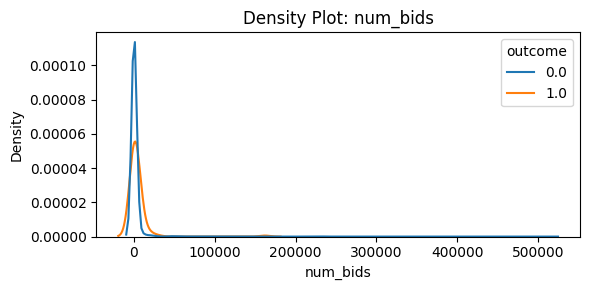

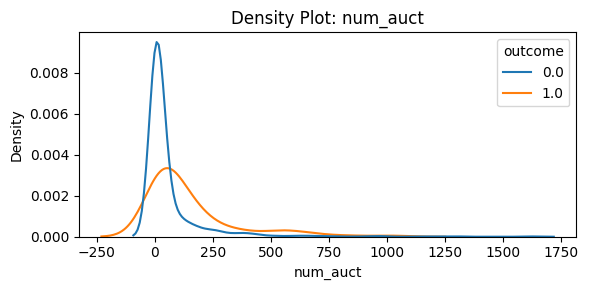

/tmp/ipykernel_35/2341782.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=train_plot_df, x=col, hue='outcome', common_norm=False)


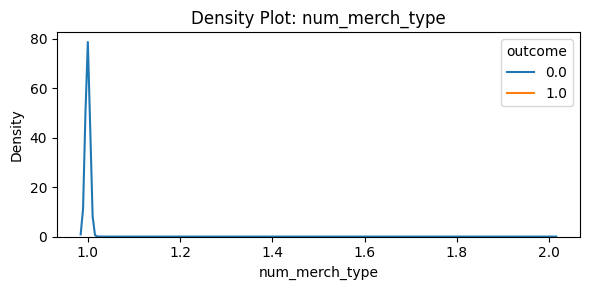

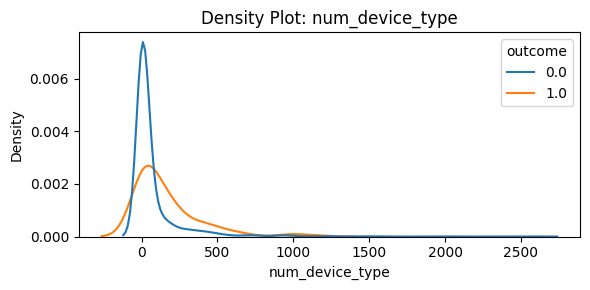

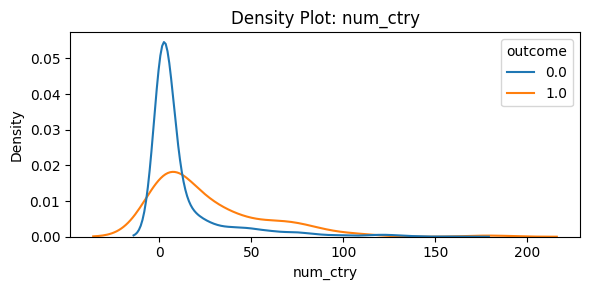

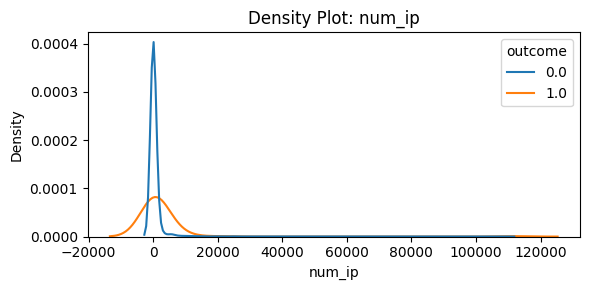

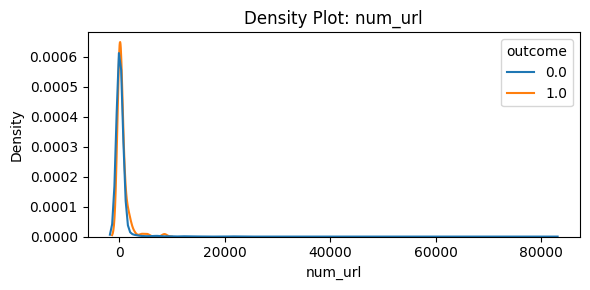

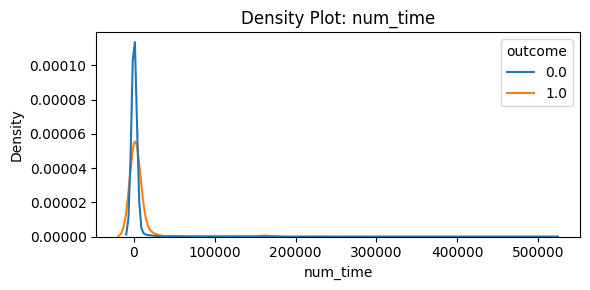

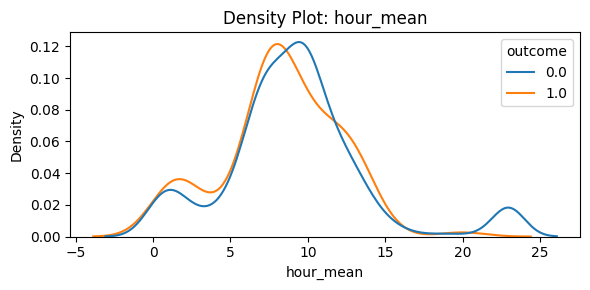

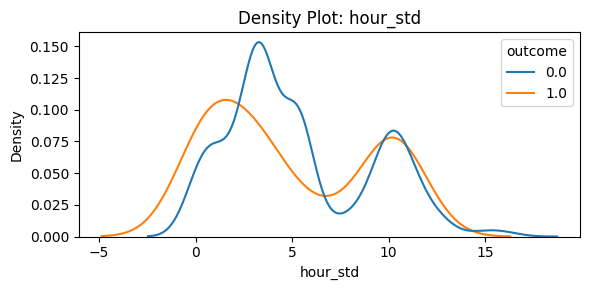

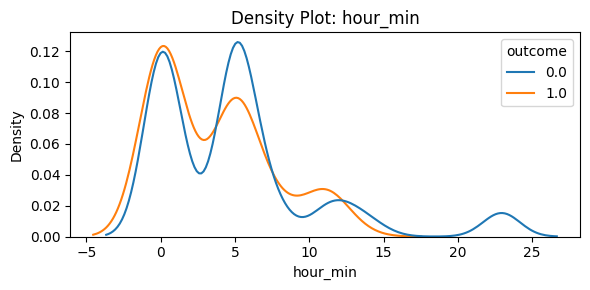

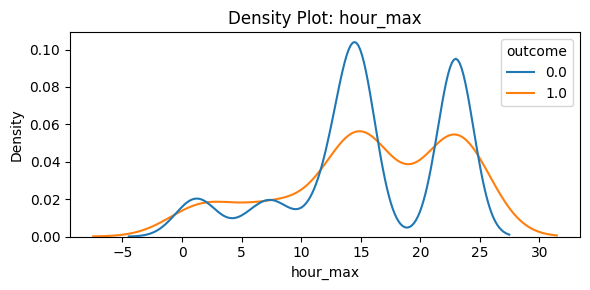

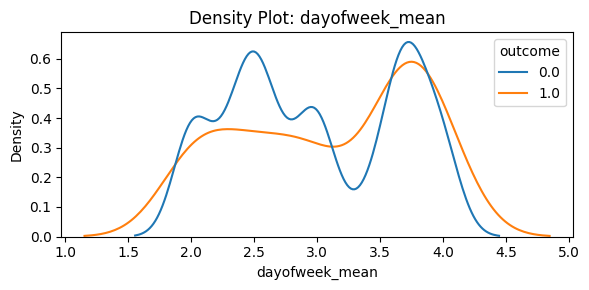

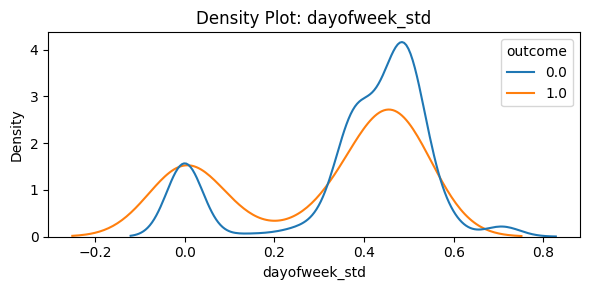

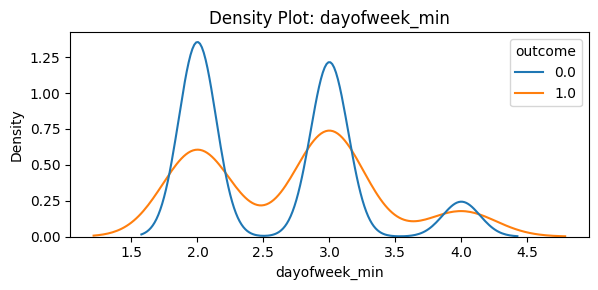

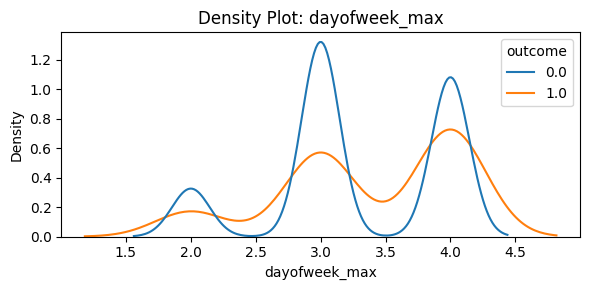

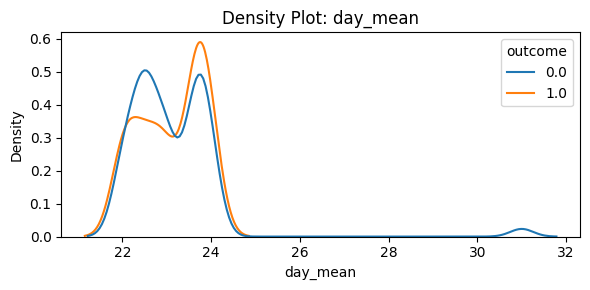

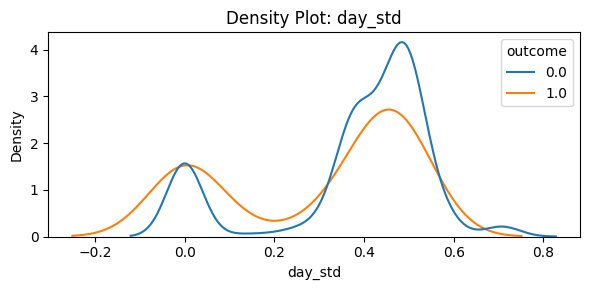

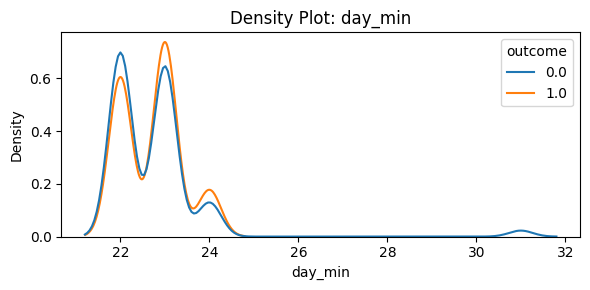

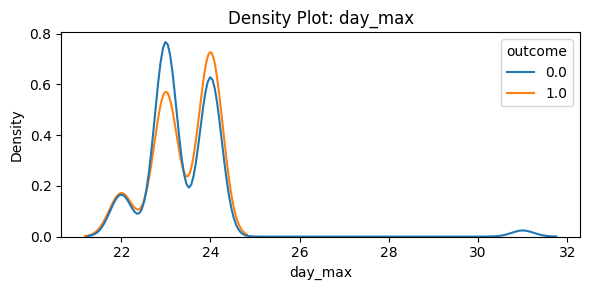

/tmp/ipykernel_35/2341782.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=train_plot_df, x=col, hue='outcome', common_norm=False)


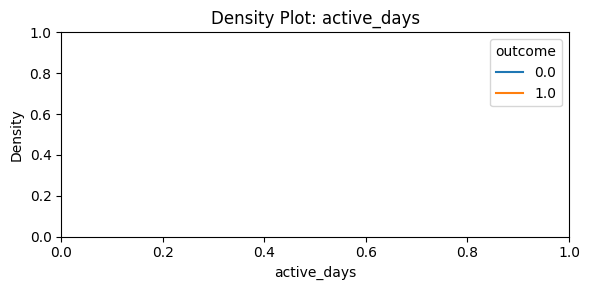

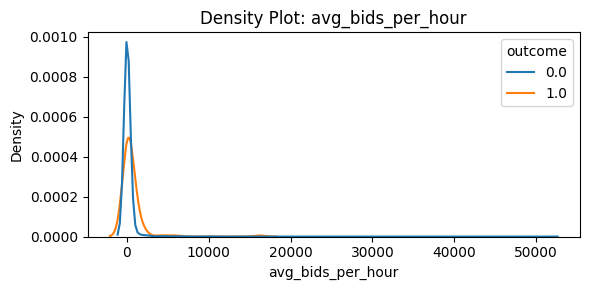

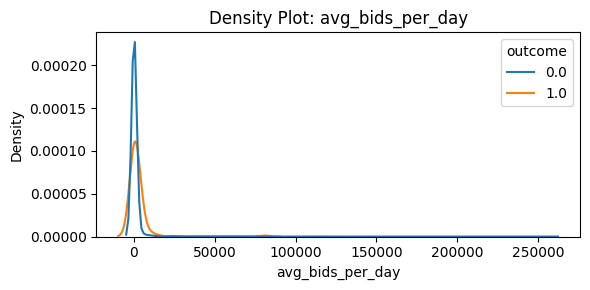

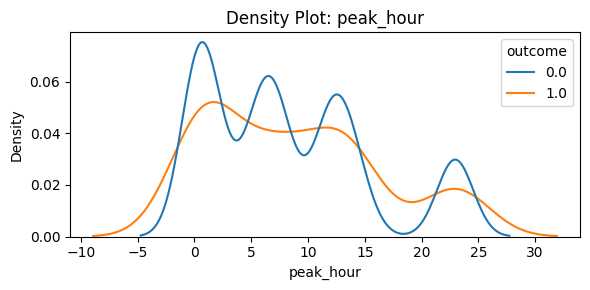

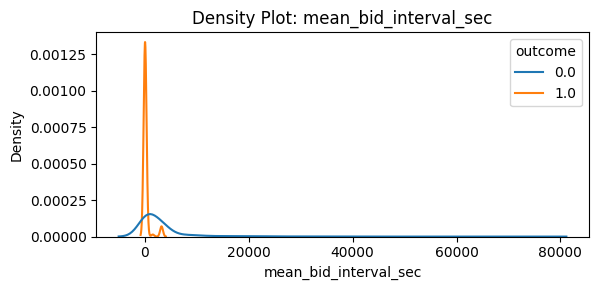

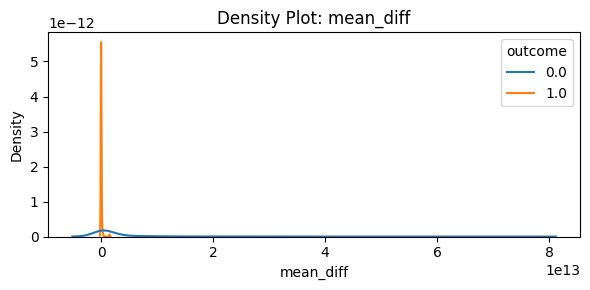

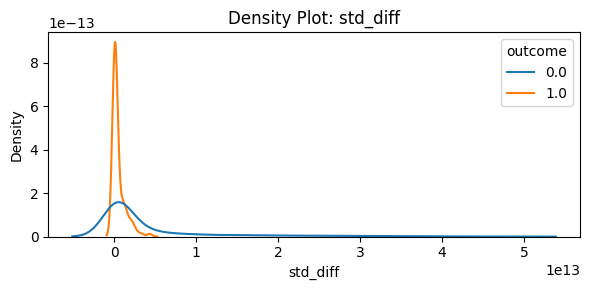

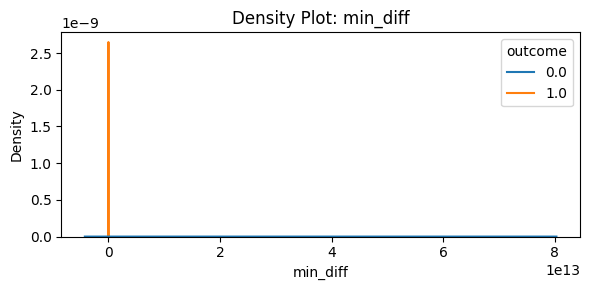

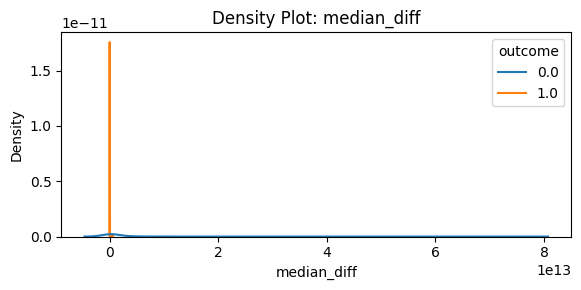

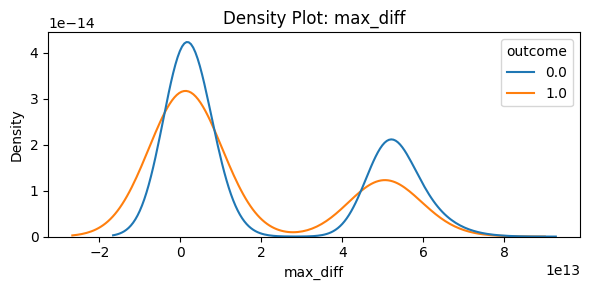

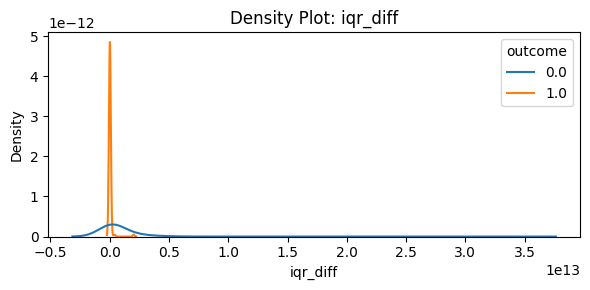

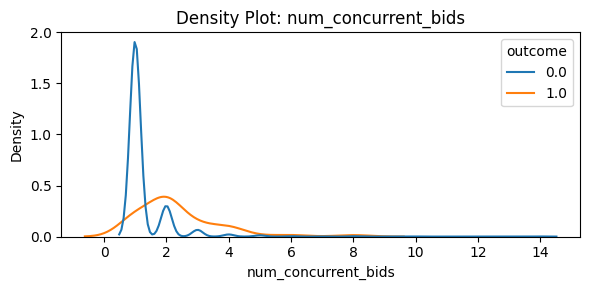

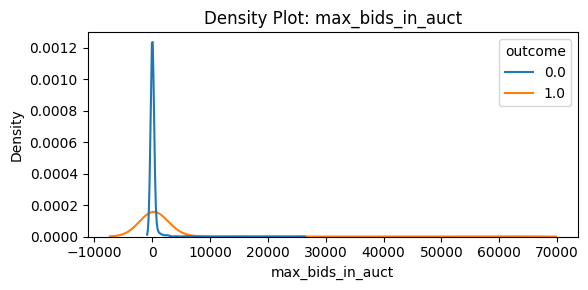

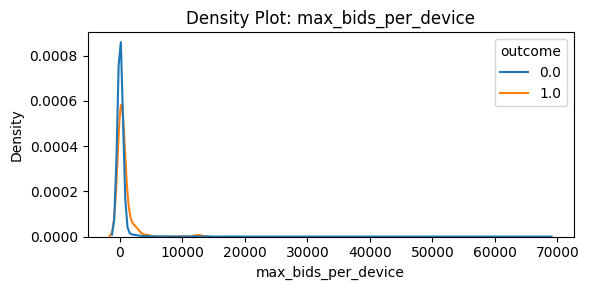

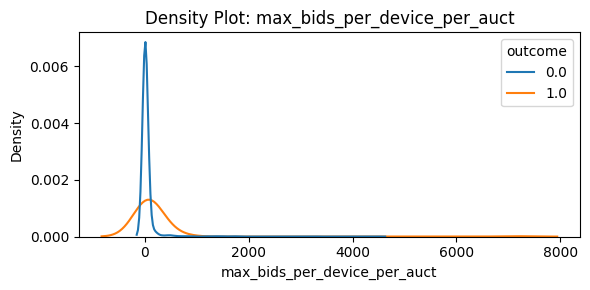

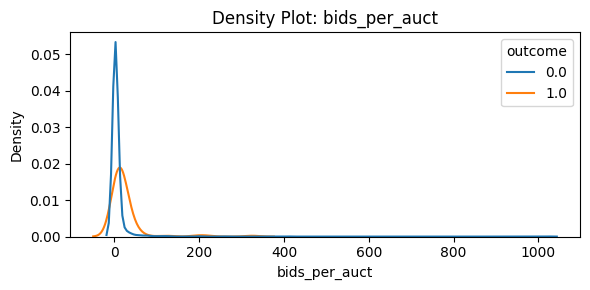

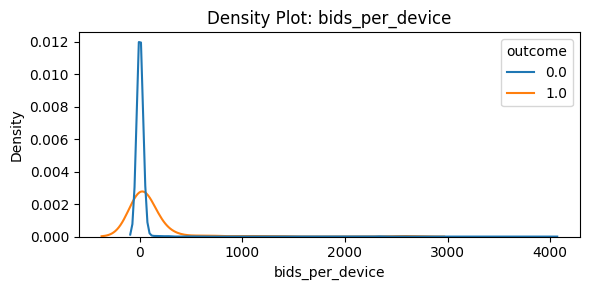

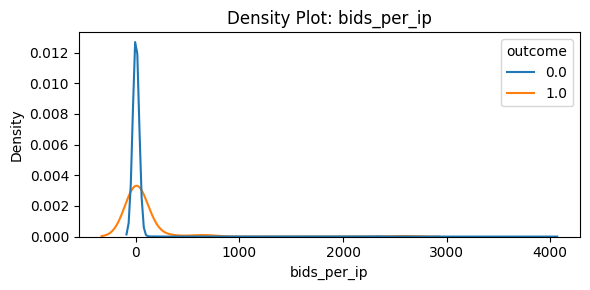

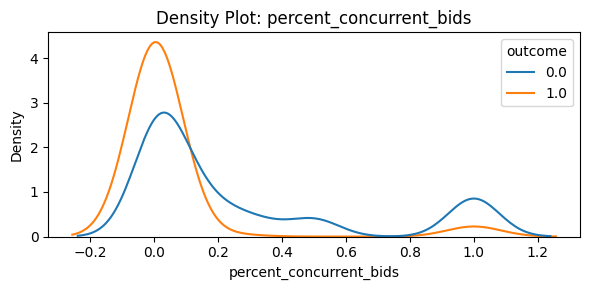

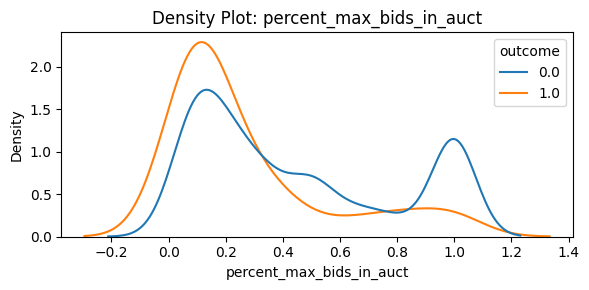

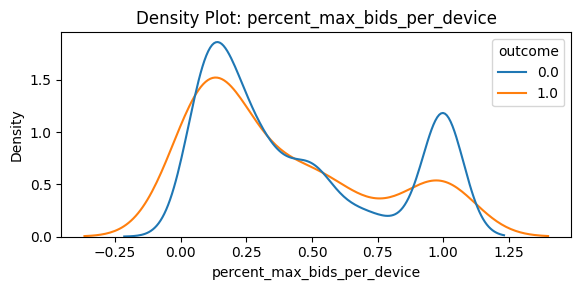

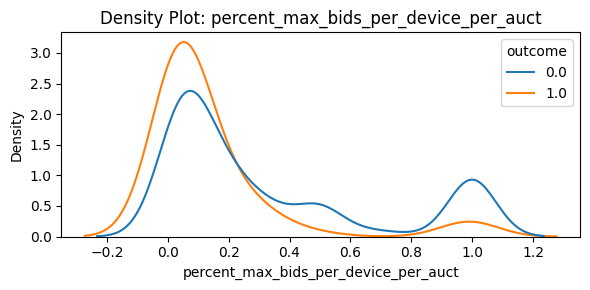

In [21]:
warnings.filterwarnings("ignore", category=FutureWarning)

for col in X_train.columns:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=train_plot_df, x=col, hue='outcome', common_norm=False)
    plt.title(f'Density Plot: {col}')
    plt.tight_layout()
    plt.show()

Observation:
- We can observe that some of the features are sghowing bad discriminative power, which is shown by the overlapping of blue and orange curve. Thus, we would eliminate those featues: num_merch_type, num_url, day_min, max_bids_per_deviceS

In [22]:
train_set = train_set.drop(columns=['num_merch_type', 'num_url', 'day_min', 'max_bids_per_device', 'avg_bids_per_day'], errors='ignore')
test_set = test_set.drop(columns=['num_merch_type', 'num_url', 'day_min', 'max_bids_per_device', 'avg_bids_per_day'], errors='ignore')

In [23]:
print(train_set.columns.tolist())

['bidder_id', 'payment_account', 'address', 'outcome', 'num_bids', 'num_auct', 'num_device_type', 'num_ctry', 'num_ip', 'num_time', 'hour_mean', 'hour_std', 'hour_min', 'hour_max', 'dayofweek_mean', 'dayofweek_std', 'dayofweek_min', 'dayofweek_max', 'day_mean', 'day_std', 'day_max', 'active_days', 'avg_bids_per_hour', 'peak_hour', 'mean_bid_interval_sec', 'mean_diff', 'std_diff', 'min_diff', 'median_diff', 'max_diff', 'iqr_diff', 'num_concurrent_bids', 'max_bids_in_auct', 'max_bids_per_device_per_auct', 'bids_per_auct', 'bids_per_device', 'bids_per_ip', 'percent_concurrent_bids', 'percent_max_bids_in_auct', 'percent_max_bids_per_device', 'percent_max_bids_per_device_per_auct']


### Feature Significance with Random Forest
Identify the most important features contributing to the model's prediction using a Random Forest classifier.

In [24]:
from sklearn.ensemble import RandomForestClassifier

X = train_set.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome'], errors='ignore')
y = train_set['outcome']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

importances = model.feature_importances_
feat_importance = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)

# Choose top N features
top_n = 20
selected_feats = [f[0] for f in feat_importance[:top_n]]

print("Top features by importance:", selected_feats)

Top features by importance: ['bids_per_device', 'avg_bids_per_hour', 'bids_per_auct', 'hour_std', 'num_device_type', 'bids_per_ip', 'num_time', 'max_bids_in_auct', 'num_bids', 'max_bids_per_device_per_auct', 'percent_concurrent_bids', 'mean_bid_interval_sec', 'percent_max_bids_per_device', 'dayofweek_std', 'day_std', 'median_diff', 'hour_mean', 'iqr_diff', 'dayofweek_mean', 'percent_max_bids_in_auct']


Visualizing Feature Importance with Random Forest

                                 feature  importance
35                         bids_per_auct    0.057285
36                       bids_per_device    0.054645
33                   max_bids_per_device    0.048152
21                     avg_bids_per_hour    0.047001
9                               hour_std    0.042558
40           percent_max_bids_per_device    0.036578
7                               num_time    0.035322
17                               day_std    0.034967
22                      avg_bids_per_day    0.033324
3                        num_device_type    0.032247
37                           bids_per_ip    0.032134
13                         dayofweek_std    0.029175
38               percent_concurrent_bids    0.028850
34          max_bids_per_device_per_auct    0.028123
28                           median_diff    0.027306
32                      max_bids_in_auct    0.027266
6                                num_url    0.027019
0                               num_bids    0.

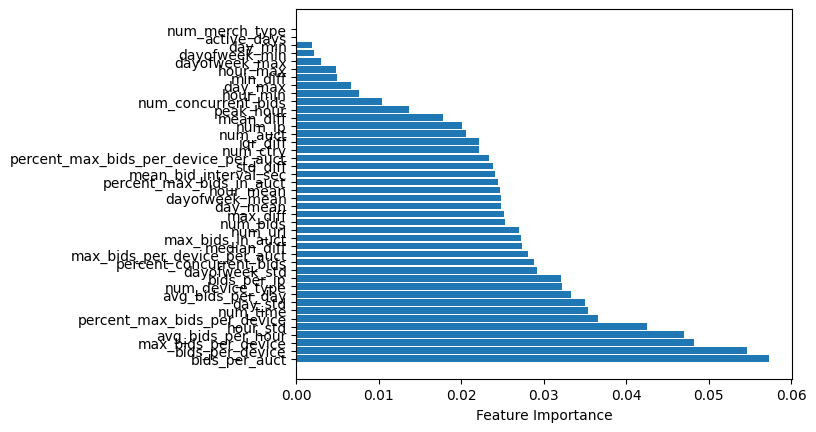

In [25]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for visualization
feat_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_importance_df)

# Plot
plt.barh(feat_importance_df['feature'], feat_importance_df['importance'])
plt.xlabel('Feature Importance')
plt.show()

## Outlier Removal

In our dataset, bidders with very few bids—especially just one—don’t provide enough data to understand their behavior properly. This lack of information can confuse the model and reduce its ability to learn meaningful patterns.

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

We printed out the bots (label = 1) that had the fewest bids to check if any bots had only one bid. It turned out there were 5 bots with only one bid, which is suspicious because bots typically place multiple bids during an auction.

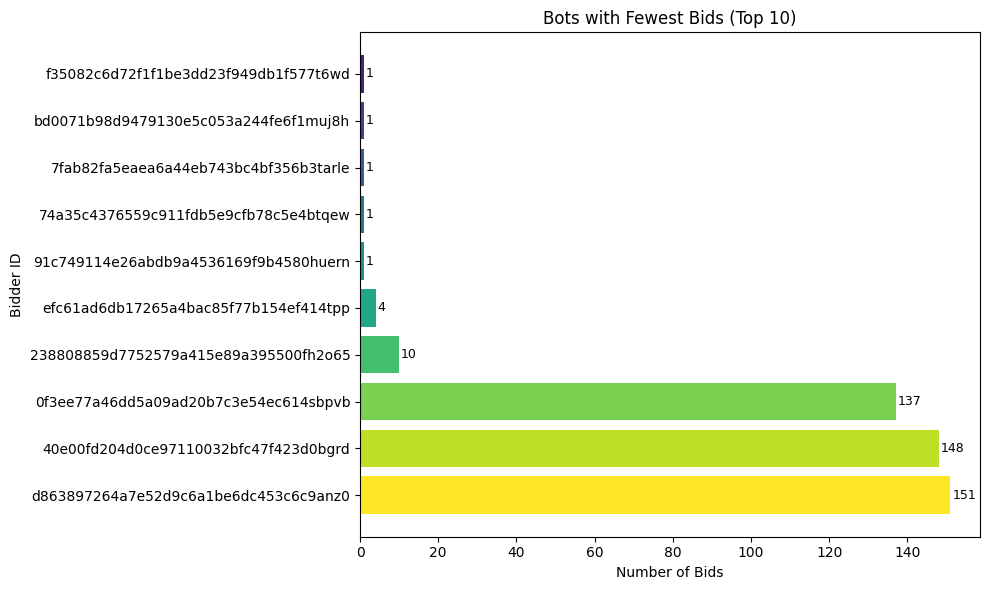

In [27]:
# Filter bots and sort by fewest bids
top_bots = train_set[train_set['outcome'] == 1].sort_values('num_bids').head(10).copy()
top_bots['rank'] = range(1, len(top_bots) + 1)

# Plot
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(top_bots['rank'] / top_bots['rank'].max())

plt.barh(top_bots['bidder_id'], top_bots['num_bids'], color=colors)
for index, value in enumerate(top_bots['num_bids']):
    plt.text(value + 0.5, index, str(value), va='center', fontsize=9)

plt.gca().invert_yaxis()  # Highest at top
plt.xlabel('Number of Bids')
plt.ylabel('Bidder ID')
plt.title('Bots with Fewest Bids (Top 10)')
plt.tight_layout()
plt.show()

Since bots with only a single bid are unlikely and such data points may harm model training, we decided to remove all bidders whose total number of bids (num_bids) equals 1. This step helps clean the dataset and improve model reliability.

In [28]:
train_set = train_set[train_set['num_bids'] > 1].reset_index(drop=True)

## Model Training

In [29]:
!pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.2 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


Import necesary libraries

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    make_scorer,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.inspection import permutation_importance
import joblib

### Data Preparation
Refine the feature set by removing potentially redundant or low-importance features based on prior analysis (KDE plots, domain knowledge, and feature importance) and define output.

In [31]:
# Drop ID and low-importance features
X = train_set.drop(columns=['bidder_id', 'payment_account', 'address', 'outcome'], errors='ignore')
features_to_drop = [
    'peak_hour', 'num_concurrent_bids', 'hour_min', 'min_diff', 
    'day_max', 'dayofweek_max', 'hour_max', 'dayofweek_min', 'active_days'
]
X = X.drop(columns=features_to_drop, errors='ignore')

y = train_set['outcome']

Select top N features using permutation importance

In [32]:
# Step 1: Resample + Scale full training data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Step 2: Train a basic model
base_model = MLPClassifier(random_state=42, max_iter=500, early_stopping=True)
base_model.fit(X_scaled, y_resampled)

# Step 3: Evaluate permutation importance
result = permutation_importance(
    base_model, X_scaled, y_resampled, scoring='roc_auc', n_repeats=10, random_state=42, n_jobs=-1
)

# Step 4: Create sorted list of top features
importances = result.importances_mean
feature_importance = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)

# Step 5: Select top N features
N = 20  # you can adjust this
top_features = [feat for feat, score in feature_importance[:N]]

print(f"Top {N} features selected based on permutation importance:")
for feat, score in feature_importance[:N]:
    print(f"{feat:30} {score:.5f}")

Top 20 features selected based on permutation importance:
percent_concurrent_bids        0.06537
std_diff                       0.04533
num_auct                       0.04394
dayofweek_std                  0.04296
num_device_type                0.04072
day_std                        0.02266
num_ip                         0.02145
hour_mean                      0.01882
mean_diff                      0.01769
percent_max_bids_per_device    0.01699
mean_bid_interval_sec          0.01646
iqr_diff                       0.01202
hour_std                       0.01117
percent_max_bids_in_auct       0.00929
median_diff                    0.00892
bids_per_device                0.00875
num_ctry                       0.00829
percent_max_bids_per_device_per_auct 0.00748
max_diff                       0.00670
bids_per_ip                    0.00638


Define K-Fold

In [33]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Use the features selected. And export the features to a csv for evaluation afterwards.

In [34]:
bidder_ids = train_set['bidder_id']

X = X[top_features]
y = train_set['outcome']

# Combine selected features with the target
X_selected = X[top_features].copy()
X_selected['outcome'] = y
X_selected['bidder_id'] = bidder_ids 

# Export to CSV
X_selected.to_csv('selected_features_with_outcome.csv', index=False)

# Optional: preview
print(X_selected.head())

   percent_concurrent_bids      std_diff  num_auct  dayofweek_std  \
0                 0.041667  7.438736e+11        18       0.442326   
1                 0.333333  1.759654e+12         1       0.000000   
2                 0.250000  8.618847e+11         4       0.000000   
3                 0.006452  2.154285e+11        23       0.391253   
4                 0.125000  2.631666e+12         8       0.517549   

   num_device_type   day_std  num_ip  hour_mean     mean_diff  \
0               14  0.442326      20   6.333333  5.711121e+11   
1                2  0.000000       3   0.666667  3.233579e+12   
2                2  0.000000       4   1.250000  2.379000e+12   
3               53  0.391253     123  18.606452  7.777888e+10   
4                2  0.517549       3  14.375000  1.598902e+12   

   percent_max_bids_per_device  ...   hour_std  percent_max_bids_in_auct  \
0                     0.250000  ...   9.760910                  0.125000   
1                     0.666667  ...   1.15

Define hyperparameter grid to try

In [35]:
param_grid = [
    {'hidden_layer_sizes': (256, 128, 64, 32), 'activation': 'relu', 'solver': 'sgd'},
    {'hidden_layer_sizes': (128, 64, 32), 'activation': 'relu', 'solver': 'adam'},
    {'hidden_layer_sizes': (512, 256), 'activation': 'tanh', 'solver': 'adam'}
]

best_score = 0
best_params = None

for params in param_grid:
    fold_scores = []
    print(f"Testing params: {params}")
    for train_idx, val_idx in kf.split(X, y):
        # Split
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Apply SMOTE only on train fold
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_resampled)
        X_val_scaled = scaler.transform(X_val)
        
        # Train model
        mlp = MLPClassifier(random_state=42, max_iter=500, early_stopping=True, **params)
        mlp.fit(X_train_scaled, y_train_resampled)
        
        # Predict and score
        y_val_pred_proba = mlp.predict_proba(X_val_scaled)[:, 1]
        score = roc_auc_score(y_val, y_val_pred_proba)
        fold_scores.append(score)
    
    avg_score = np.mean(fold_scores)
    print(f"Average ROC-AUC for params {params}: {avg_score:.4f}")
    
    if avg_score > best_score:
        best_score = avg_score
        best_params = params

print("\nBest hyperparameters found:")
print(best_params)
print(f"With average ROC-AUC: {best_score:.4f}")

Testing params: {'hidden_layer_sizes': (256, 128, 64, 32), 'activation': 'relu', 'solver': 'sgd'}
Average ROC-AUC for params {'hidden_layer_sizes': (256, 128, 64, 32), 'activation': 'relu', 'solver': 'sgd'}: 0.8640
Testing params: {'hidden_layer_sizes': (128, 64, 32), 'activation': 'relu', 'solver': 'adam'}
Average ROC-AUC for params {'hidden_layer_sizes': (128, 64, 32), 'activation': 'relu', 'solver': 'adam'}: 0.8599
Testing params: {'hidden_layer_sizes': (512, 256), 'activation': 'tanh', 'solver': 'adam'}
Average ROC-AUC for params {'hidden_layer_sizes': (512, 256), 'activation': 'tanh', 'solver': 'adam'}: 0.8884

Best hyperparameters found:
{'hidden_layer_sizes': (512, 256), 'activation': 'tanh', 'solver': 'adam'}
With average ROC-AUC: 0.8884


### Model Training with Evaluation

Train the final MLP model using the best hyperparameters we found during the cross-validation search.

In [36]:
# Train MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256),
    activation='tanh',
    solver='adam',
    random_state=42,
    max_iter=500,
    early_stopping=True
)
mlp.fit(X_train_scaled, y_train_resampled)

# Evaluate on validation set
y_pred = mlp.predict(X_val_scaled)
y_pred_proba = mlp.predict_proba(X_val_scaled)[:, 1]

print(f"Number of iterations: {mlp.n_iter_}")
print(f"Final loss: {mlp.loss_}\n")

print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("AUC-ROC:", roc_auc_score(y_val, y_pred_proba))

Number of iterations: 17
Final loss: 0.2507093879149085

Confusion Matrix:
 [[256  60]
 [  5  15]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.81      0.89       316
         1.0       0.20      0.75      0.32        20

    accuracy                           0.81       336
   macro avg       0.59      0.78      0.60       336
weighted avg       0.93      0.81      0.85       336

AUC-ROC: 0.888132911392405


Average ROC-AUC: 0.8889
Average Recall: 0.7463
Average Precision: 0.2373
Average F1-Score: 0.3592


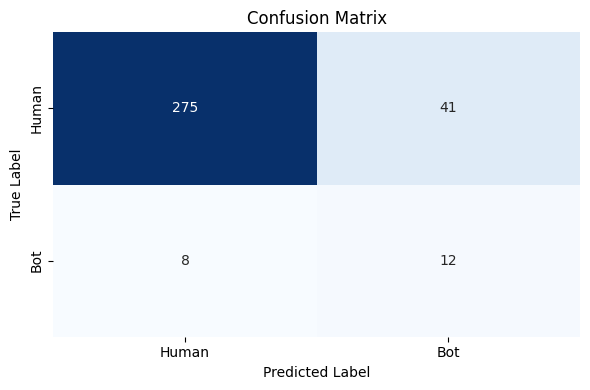

In [45]:
roc_auc_scores = []
recall_scores = []
precision_scores = []
f1_scores = []

for train_index, val_index in kf.split(X, y):
    # Split data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Resample training data with SMOTE to balance classes
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # Scale features
    scaler = StandardScaler()
    X_train_res_scaled = scaler.fit_transform(X_train_res)
    X_val_scaled = scaler.transform(X_val)
    
    # Initialize and train MLP model
    mlp = MLPClassifier(random_state=42, max_iter=500, early_stopping=True)
    mlp.fit(X_train_res_scaled, y_train_res)
    
    # Predict probabilities and classes on validation set
    y_val_proba = mlp.predict_proba(X_val_scaled)[:, 1]
    y_val_pred = mlp.predict(X_val_scaled)
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_val, y_val_proba)
    recall = recall_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)
    cm = confusion_matrix(y_val, y_val_pred)
    
    # Append scores
    roc_auc_scores.append(roc_auc)
    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)

    
# Print average scores across folds
print(f"Average ROC-AUC: {np.mean(roc_auc_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average F1-Score: {np.mean(f1_scores):.4f}")

# Visualize each confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
        xticklabels=["Human", "Bot"], yticklabels=["Human", "Bot"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Save the model for evaluation and comparison purpose.

In [38]:
joblib.dump(mlp, 'mlp_best_model.pkl')

['mlp_best_model.pkl']

## Generate Prediction on Test Data

In [39]:
# --- Prediction Generation ---

# Step 1: Store bidder_id for final output
bidder_ids = test_set['bidder_id']

# Step 2: Prepare test features (drop non-predictive columns)
X_test = test_set[top_features]

# Step 3: Scale test features using the scaler fitted on training data
X_test_scaled = scaler.transform(X_test)

# Step 4: Generate predicted probabilities for class 1 (robot)
predictions = mlp.predict_proba(X_test_scaled)[:, 1]

# Step 5: Create submission DataFrame
submission = pd.DataFrame({
    'bidder_id': bidder_ids,
    'prediction': predictions
})

# Step 6: Export to CSV
submission.to_csv('submission.csv', index=False)

# Step 7: Preview the output
print(submission.head())

                               bidder_id    prediction
0  49bb5a3c944b8fc337981cc7a9ccae41u31d7  6.173920e-24
1  a921612b85a1494456e74c09393ccb65ylp4y  3.276520e-34
2  6b601e72a4d264dab9ace9d7b229b47479v6i  1.609803e-22
3  eaf0ed0afc9689779417274b4791726cn5udi  4.880538e-61
4  cdecd8d02ed8c6037e38042c7745f688mx5sf  7.482102e-11
